Fahrzeug Positionsbestimmung bei Linearer Bewegung

### Annahmen für das Versuch

Wir fahren mit konstanter Geschwindigkeit. Die Geschwindigkeit kann mittels der Radgeschwindigkeit ermittelt werden.

![KalmanFilter](Kalman-Filter-Step.png)

### Zustandsvektoren

$$
    x_k = 
    \begin{pmatrix}
    x & y & \dot x & \dot y
    \end{pmatrix}
    = 
    \begin{pmatrix}
    X Position & Y Position & v_x & v_y
    \end{pmatrix}
$$


Mit Formeln aus Physik ergibt die Gleichung $ x_{k+1} = Ax_k$:


$$
    x_{k+1} = 
    \begin{pmatrix}
    1 & 0 & \Delta t & 0 \\
    0 & 1 & 0 & \Delta t \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    \end{pmatrix}
    *
    \begin{pmatrix}
    x & y & \dot x & \dot y
    \end{pmatrix}
$$

Unsere Beobachtungsmodell ist $ y = Gx $:

$$
    y =
    \begin{pmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1
    \end{pmatrix}
    *
    x
$$
Das bedeutet wir beobachten die Geschwindigkeit in der richtigen Einheit.

### Startzustand $x_0$

$$
    x_0 =
    \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    0 \\
    \end{pmatrix}
$$

mit

$$
    \Sigma_0 = 
    \begin{pmatrix}
    \sigma _{x}^2 & 0 & 0 & 0 \\
    0 & \sigma _{y}^2 & 0 & 0 \\
    0 & 0 & \sigma _{\dot x}^2 & 0 \\
    0 & 0 & 0 & \sigma _{\dot y}^2
    \end{pmatrix}
$$
ist der Unsicherheitsmatrix (Kovarianzmatrix) in Schritt $k = 0$ mit $\sigma$ Standardabweichung.

In [1]:
using LinearAlgebra, Plots, DataFrames, Distributions
# plotly()
upscale = 1
default(line = (:steppre, 0.5, 1, 2), size=(800*upscale,600*upscale))

In [2]:
Σ_0 = Matrix{Float64}(I, 4, 4) .* 1000
x_0 = zeros(4, 1)

4×1 Array{Float64,2}:
 0.0
 0.0
 0.0
 0.0

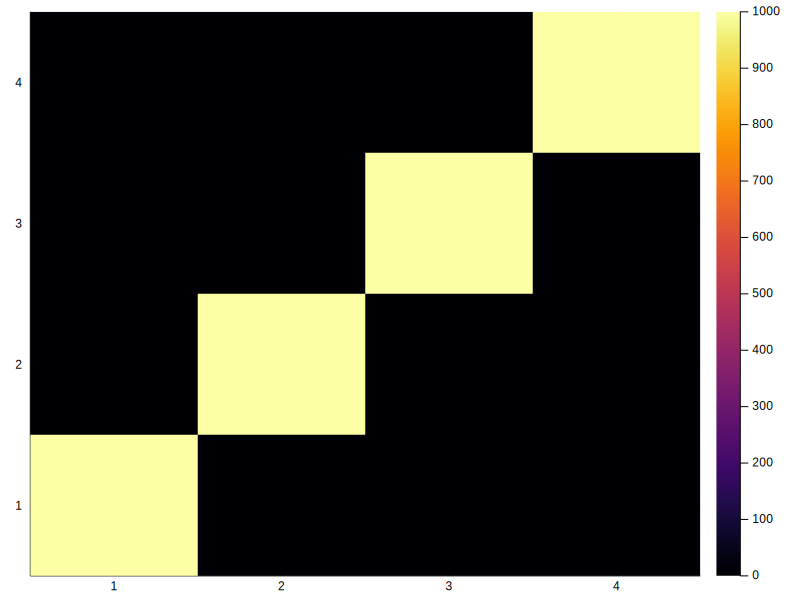

In [3]:
heatmap(Σ_0, seriescolor = :inferno)

### Zustandsübergangsmatrix $A$

// In jedem (Zeit-)Berechnungsschritt muss das Zustandsübergangsmatrix $ A $ neu berechnet werden. -->


In [4]:
Δ_t = 0.1
A = [1 0 Δ_t 0;
     0 1 0 Δ_t;
     0 0 1 0;
     0 0 0 1]

4×4 Array{Float64,2}:
 1.0  0.0  0.1  0.0
 0.0  1.0  0.0  0.1
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

### Messmatrix $ G $

Wir messen $\dot x$ und $\dot y$ direkt.

In [5]:
G = [0 0 1 0;
     0 0 0 1]


2×4 Array{Int64,2}:
 0  0  1  0
 0  0  0  1

### Messrauschen Kovarianz $R$

R zeigt, wie genau die Messung war.

$$
    R =
    \begin{pmatrix}
    \sigma_{\dot x}^2 & 0 \\
    0 & \sigma_{\dot y}^2
    \end{pmatrix}
$$

In [6]:
σ = 10^2
R = [σ 0;
     0 σ]

2×2 Array{Int64,2}:
 100    0
   0  100

### Prozessrauschen Kovarianzmatrix $Q$

Die Position des Fahrzeugs wird von äußeren Faktoren beeinflusst, wie z. B. der Wind oder rutschige Fahrbahn. Dies kann man mithilfe des Kovarianzmatrixes $Q$ modelliert werden.

$$
    Q = \begin{pmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{pmatrix}
$$

$Q$ kann berechnet werden als $ Q = G \cdot G^T \cdot \sigma_v^2$ mit 
$G = \begin{pmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{pmatrix}^T$ und $\sigma_v$ als die Beschleunigungsprozessrauschen. Diese kann nach  Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). Empirical evaluation of vehicular models for ego motion estimation als $8.8 m/s^2$ angenähert werden.

In [7]:
σ_v = 8.8
Gravity = transpose([ 0.5 * Δ_t^2 0.5 * Δ_t^2 Δ_t Δ_t ])
Q = Gravity * transpose(Gravity) * σ_v^2

4×4 Array{Float64,2}:
 0.001936  0.001936  0.03872  0.03872
 0.001936  0.001936  0.03872  0.03872
 0.03872   0.03872   0.7744   0.7744 
 0.03872   0.03872   0.7744   0.7744 

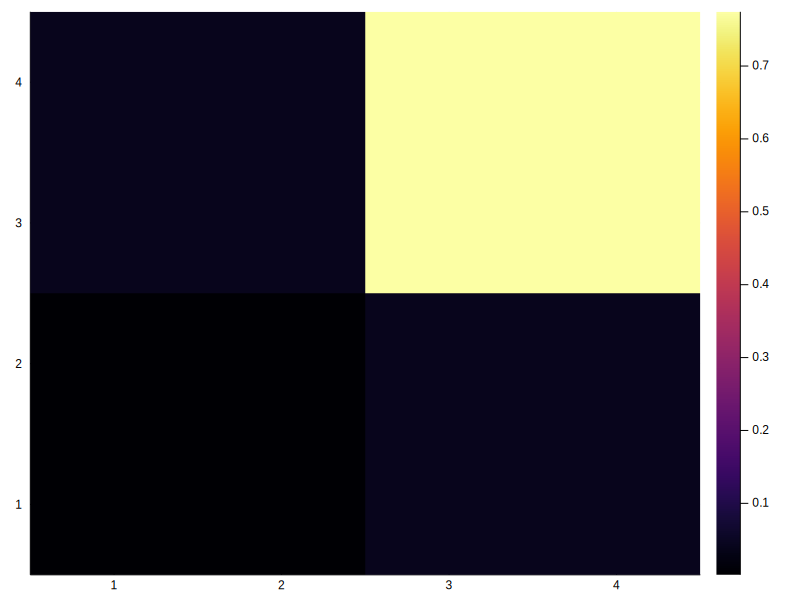

In [8]:
heatmap(Q)

### Messdaten
Im nächsten Schritt generieren wir messdaten.

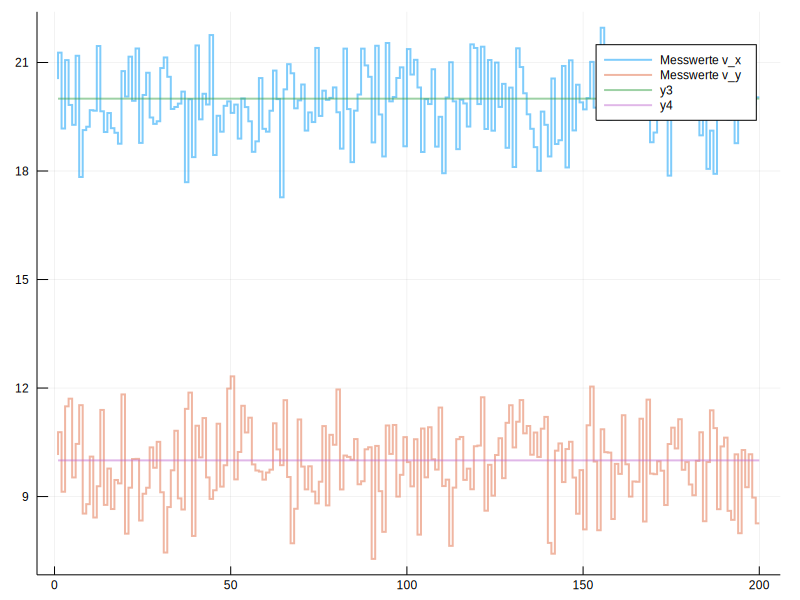

In [9]:
n = 200
v_x = 20
v_y = 10

m_x = rand(Normal(0, 1), n, 1) .+ v_x
m_y = rand(Normal(0, 1), n, 1) .+ v_y

plot(1:200, m_x, label = "Messwerte v_x", line = (:steppre, 0.5, 1, 2))
plot!(1:200, m_y, label = "Messwerte v_y", line = (:steppre, 0.5, 1, 2))
plot!(1:200, (x) -> 20)
plot!(1:200, (x) -> 10)

In [10]:
# IJulia.load("../Kalman.jl")
include("../KalmanFilter.jl")
using .KalmanFilter

In [11]:
model = Kalman(A, Q, G, R, x_0, Σ_0)
y(i) = [m_x[i]; m_y[i]]
predicted = zeros(Float64, 4, n)
fusioned = zeros(Float64, 4, n)
confidence = zeros(Float64, 4, 4, n)
gains = zeros(Float64, 2, 4, n)
for i = 1:n
    y_cur = y(i)
    fusion(model, y_cur)
    fusioned[:, i] = model.x̂
    predict(model)
    predicted[:, i] = model.x̂
#     confidence[i] = model.Σ
    gains[:, :, i] = reshape(K(model), (2, 4, 1))
end
output = DataFrame(fusioned', [:pX, :pY, :vX, :vY])

plt = plot(1, xlim = (0, 400), ylim = (0, 200), label = "Gefilterte Laufbahn")
plot!((x) -> 0.5x, linestyle = :dot, seriestype = :line, label = "Theoretische Laufbahn")
@gif for i = eachrow(output)
    push!(plt, i.pX, i.pY)
end

┌ Info: Saved animation to 
│   fn = /home/meszlenyilorant/bachelorarbeit/notebooks/carposition/tmp.gif
└ @ Plots /home/meszlenyilorant/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/home/meszlenyilorant/bachelorarbeit/notebooks/carposition/tmp.gif")

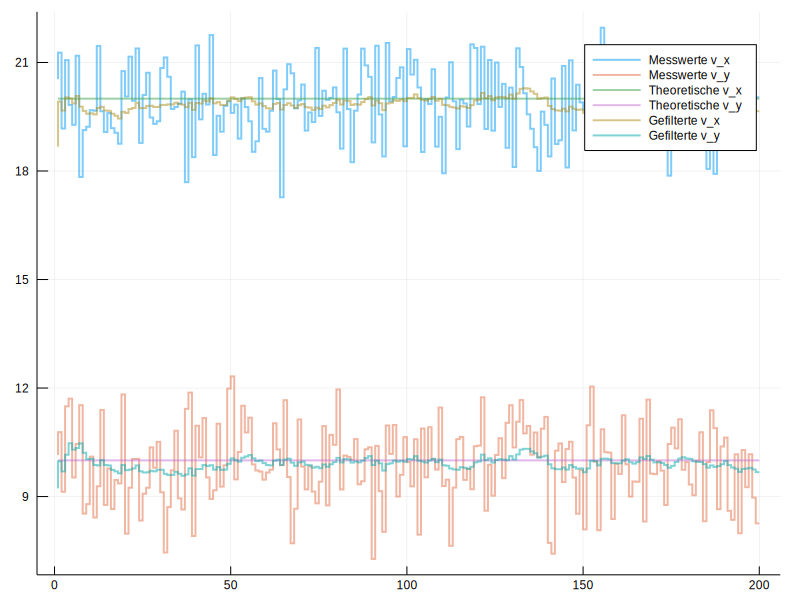

In [12]:
plot(1:200, m_x, label = "Messwerte v_x", line = (:steppre, 0.5, 1, 2))
plot!(1:200, m_y, label = "Messwerte v_y", line = (:steppre, 0.5, 1, 2))
plot!(1:200, (x) -> 20, label = "Theoretische v_x")
plot!(1:200, (x) -> 10, label = "Theoretische v_y")
plot!(1:200, output.vX, label = "Gefilterte v_x")
plot!(1:200, output.vY, label = "Gefilterte v_y")